In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import matplotlib.pyplot as plt
import torch

from agent import Agent, add_noise
from hill_climbing import perform_hill_climbing

https://openai.com/requests-for-research/#cartpole

## Explore `gym` and the `CartPole-v0` environment

In [3]:
env = gym.envs.make('CartPole-v0')

/anaconda3/envs/drl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
env.reset()

array([-0.03575592, -0.0041878 , -0.04159279,  0.00454044])

In [5]:
env.action_space

Discrete(2)

In [6]:
env.observation_space

Box(4,)

Watch an untrained agent

In [7]:
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
cartpole_agent.watch_me(env, steps=300)

## Apply Hill Climbing Algorithm to solve Environment

In [8]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=4,
                       stochastic=True)
n_episodes = 1000
initial_noise_std = 0.01

In [9]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  initial_noise_std=initial_noise_std,
                                                  population_size=1)

Start with Return Estimate G = 38.0
Episode 0	Average Score: 27.00
Episode 2 - Improved G to G_best = 49.0
Episode 6 - Improved G to G_best = 54.0
Episode 19 - Improved G to G_best = 55.0
Episode 100	Average Score: 22.78
Episode 155 - Improved G to G_best = 82.0
Episode 200	Average Score: 20.60
Episode 300	Average Score: 20.58
Episode 400	Average Score: 20.95
Episode 500	Average Score: 20.60
Episode 600	Average Score: 19.49
Episode 700	Average Score: 20.86
Episode 800	Average Score: 22.94
Episode 900	Average Score: 20.90


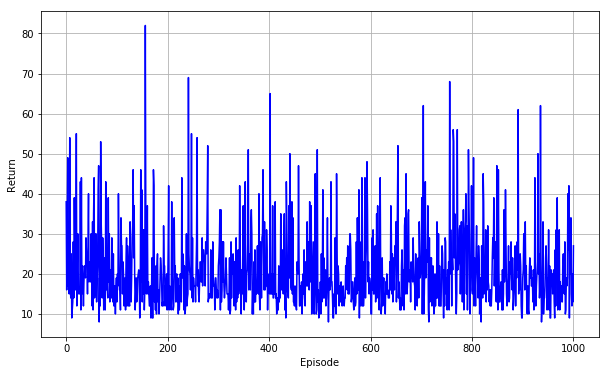

In [10]:
plt.figure(figsize=(10,6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

Watch a (slightly) improved agent

In [11]:
opt_agent.watch_me(env, steps=500)

## Change over to Steepest Ascent Hill Climbing and its Flavors

### without adaptive noise

In [12]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=4)
n_episodes = 500
initial_noise_std = 0.01
population_size = 30
use_adaptive_noise = False

In [13]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise)

Start with Return Estimate G = 11.0
Episode 0 - Improved G to G_best = 59.0
Episode 0	Average Score: 35.00
Episode 14 - Improved G to G_best = 65.0
Episode 18 - Improved G to G_best = 83.0
Episode 19 - Improved G to G_best = 90.0
Episode 100	Average Score: 49.17
Episode 134 - Improved G to G_best = 102.0
Episode 200	Average Score: 53.90
Episode 300	Average Score: 51.18
Episode 400	Average Score: 50.35
Episode 462 - Improved G to G_best = 138.0


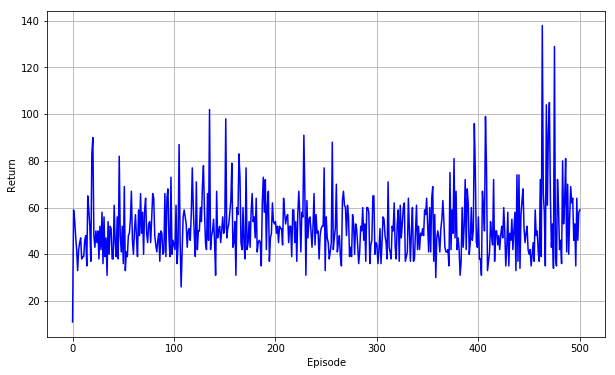

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [15]:
opt_agent.watch_me(env, steps=500)

### with adaptive noise

In [17]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=4,
                       stochastic=True)
n_episodes = 500
initial_noise_std = 0.01
population_size = 30
use_adaptive_noise = True

In [18]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise)

Start with Return Estimate G = 11.0
Episode 0 - Improved G to G_best = 46.0
Episode 0	Average Score: 28.50
Episode 1 - Improved G to G_best = 55.0
Episode 9 - Improved G to G_best = 57.0
Episode 11 - Improved G to G_best = 67.0
Episode 15 - Improved G to G_best = 200.0
Episode 100	Average Score: 178.13
Environment solved in 12 episodes!	Average Score: 195.38


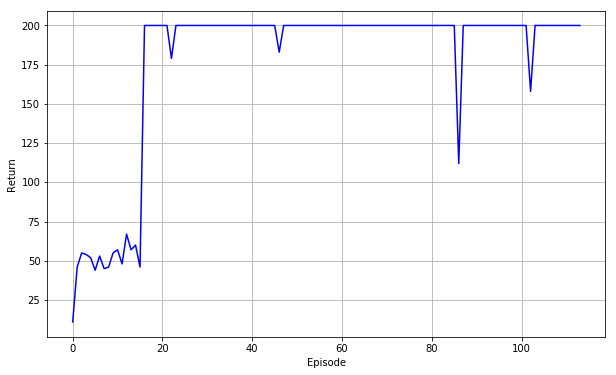

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [20]:
opt_agent.watch_me(env, steps=500)

### Use Cross Entropy Metod

In [21]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=4)
n_episodes = 400
initial_noise_std = 0.01
population_size = 30
cem_frac = 0.25
use_adaptive_noise = False
use_cem = True

In [22]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  cem_frac=cem_frac,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise,
                                                  use_cem=use_cem)

Start with Return Estimate G = 13.0
Episode 0 - Improved G to G_best = 37.42857142857143
Episode 0	Average Score: 25.21
Episode 3 - Improved G to G_best = 44.0
Episode 35 - Improved G to G_best = 48.57142857142857
Episode 44 - Improved G to G_best = 49.857142857142854
Episode 84 - Improved G to G_best = 54.714285714285715
Episode 100	Average Score: 35.26
Episode 200	Average Score: 34.90
Episode 300	Average Score: 35.48


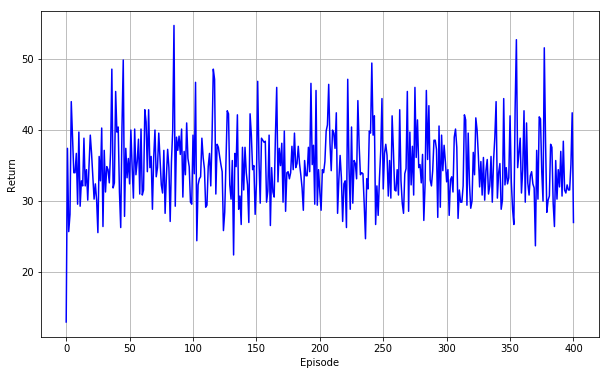

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [24]:
opt_agent.watch_me(env, steps=500)

## Use Evolution Strategy

In [36]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=4)
n_episodes = 400
initial_noise_std = 0.01
population_size = 30
use_adaptive_noise = True
use_evolution = True

In [37]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise,
                                                  use_evolution=use_evolution)

Start with Return Estimate G = 11.0
Episode 0 - Improved G to G_best = 15.0
Episode 0	Average Score: 13.00
Episode 2 - Improved G to G_best = 24.0
Episode 9 - Improved G to G_best = 77.0
Episode 19 - Improved G to G_best = 151.0
Episode 22 - Improved G to G_best = 190.0
Episode 25 - Improved G to G_best = 200.0
Episode 100	Average Score: 153.51
Episode 200	Average Score: 183.95
Episode 300	Average Score: 186.30


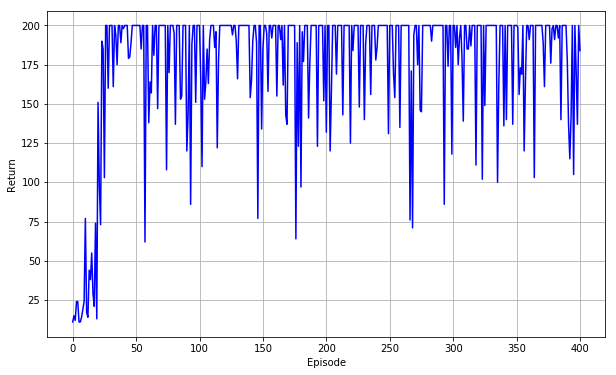

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [39]:
opt_agent.watch_me(env, steps=500)

## Conclusion

* Methods that were able to solve the environment:
    * Steepest Ascent Hill Climbing with Adaptive Noise
    * Evolution Strategy (almost)